In [21]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

In [22]:
#Datos de drive

from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('drive/MyDrive/Ciencia de datos/Taller 2/train.csv')
pred = pd.read_csv('drive/MyDrive/Ciencia de datos/Taller 2/pred.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
train.head(1)

,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,5191.0,0


In [24]:
pred.head(1)

,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed
0,12692,37,technician,single,university.degree,no,no,no,cellular,jul,mon,3,999,0,nonexistent,1.4,93.918,-42.7,5228.1


# 1) Análisis exploratorio de datos

### 1.1 Unión de datasets

De esta manera se facilita la futura limpieza y transformación de datos.

In [25]:
#Creación de columna para identificar dataset
train['dataset'] = 'train'
pred['dataset'] = 'pred'

#Asignación de índice
train.set_index('id', inplace=True)
pred.set_index('id', inplace=True)

#Union de datasets
train_pred = train.append(pred)
train_pred.tail(1)

<ipython-input-25-b5dd72db1450>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_pred = train.append(pred)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset
id,,,,,,,,,,,,,,,,,,,,
39221,34,admin.,single,university.degree,no,no,no,cellular,mar,tue,1,6,1,success,-1.8,93.369,-34.8,5008.7,NaN,pred


### 1.2 Revisión de columnas

In [26]:
train_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41188 entries, 0 to 39221
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  nr.employed     41188 non-null 

### 1.2 Revsión variables categóricas

Se observa que no hay datos nulos, sin embargo, para algunas de las variables categóricas existe la categoría 'unknown', por lo que vale la pena analisar cuales vale la pena modificar.

In [27]:
train.groupby('job').agg(trabajo=('job','count')).sort_values('trabajo',ascending=False)

,trabajo
job,
admin.,10155
blue-collar,9041
technician,6580
services,3881
management,2840
retired,1676
entrepreneur,1420
self-employed,1388
housemaid,1028


In [28]:
train.groupby('marital').agg(estado=('marital','count')).sort_values('estado',ascending=False)

,estado
marital,
married,24343
single,11266
divorced,4491
unknown,79


In [29]:
train.groupby('education').agg(educacion=('education','count')).sort_values('educacion',ascending=False)

,educacion
education,
university.degree,11825
high.school,9304
basic.9y,5898
professional.course,5117
basic.4y,4074
basic.6y,2249
unknown,1694
illiterate,18


La variable 'education' tiene muchas categorías, por lo que vale la pena agruparlas

In [30]:
train.groupby('default').agg(has_default=('default','count')).sort_values('has_default',ascending=False)

,has_default
default,
no,31762
unknown,8414
yes,3


La mayoría de la información que aporta la variable 'default' es la misma, aún sustituyendo los unkwonn por la moda, por lo que es una variable que puede ser eliminada

In [31]:
train.groupby('housing').agg(has_house=('housing','count')).sort_values('has_house',ascending=False)

,has_house
housing,
yes,21033
no,18174
unknown,972


In [32]:
train.groupby('loan').agg(has_loan=('loan','count')).sort_values('has_loan',ascending=False)

,has_loan
loan,
no,33116
yes,6091
unknown,972


In [33]:
train.groupby('month').agg(which_month=('month','count')).sort_values('which_month',ascending=False)

,which_month
month,
may,13469
jul,7013
aug,6004
jun,5179
nov,4012
apr,2559
oct,693
sep,551
mar,522


La variable 'mont' tiene muchas categorías, por lo que vale la pena agruparlas. En este caso, puede ser por trimestres

In [34]:
train.groupby('day_of_week').agg(which_day=('day_of_week','count')).sort_values('which_day',ascending=False)

,which_day
day_of_week,
thu,8396
mon,8290
wed,7966
tue,7884
fri,7643


In [35]:
train.groupby('poutcome').agg(outcome=('poutcome','count')).sort_values('outcome',ascending=False)

,outcome
poutcome,
nonexistent,34736
failure,4135
success,1308


### 1.3 Información que nos dan los datos

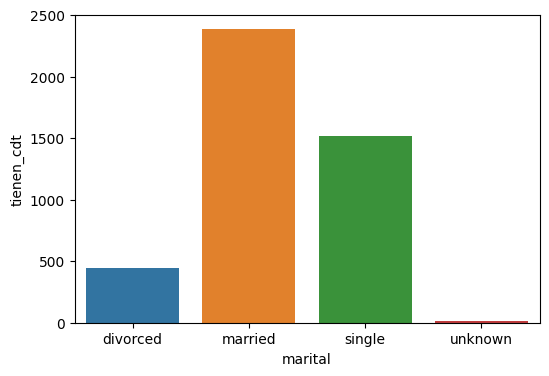

In [36]:
#Marital
cdt_marital = train.groupby('marital').agg(tienen_cdt=('target','sum')).reset_index()
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=cdt_marital, x='marital', y='tienen_cdt');

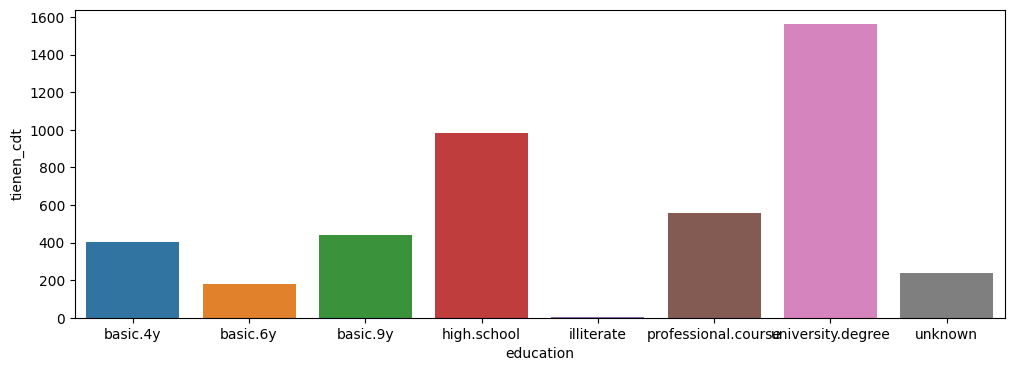

In [37]:
#Education
cdt_education = train.groupby('education').agg(tienen_cdt=('target','sum')).reset_index()
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=cdt_education, x='education', y='tienen_cdt');

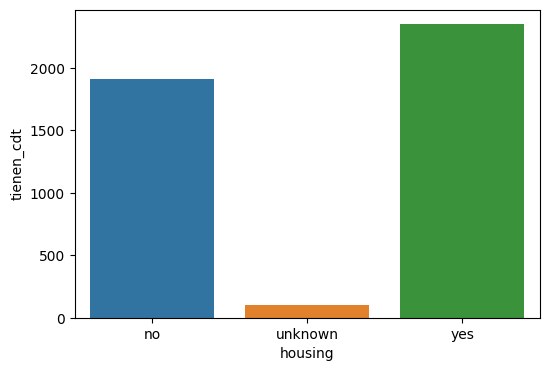

In [38]:
#House
cdt_house = train.groupby('housing').agg(tienen_cdt=('target','sum')).reset_index()
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=cdt_house, x='housing', y='tienen_cdt');

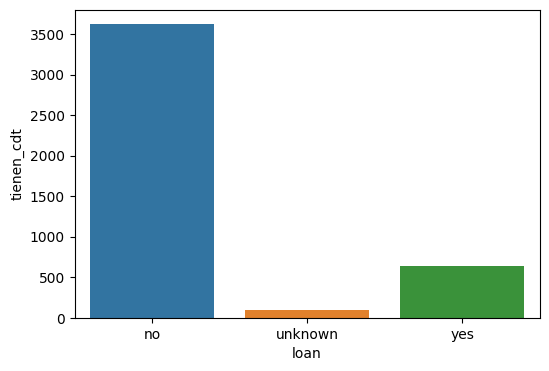

In [39]:
#Loan
cdt_loan = train.groupby('loan').agg(tienen_cdt=('target','sum')).reset_index()
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=cdt_loan, x='loan', y='tienen_cdt');

Se observa que la mayoría de personas que invirtieron en un CDT no tienen préstamos. En general, la gente con préstamos es menor a la gente sin préstamos. A pesar de esto, para ambas categorías se observan numeros significativamente menores al de clientes totales, por lo que se tarta de un dataset desbalanceado

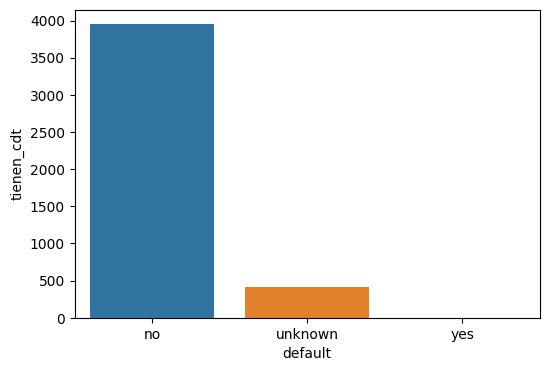

In [40]:
#default
cdt_default = train.groupby('default').agg(tienen_cdt=('target','sum')).reset_index()
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=cdt_default, x='default', y='tienen_cdt');

Default se eliminará, no aporta información relevante

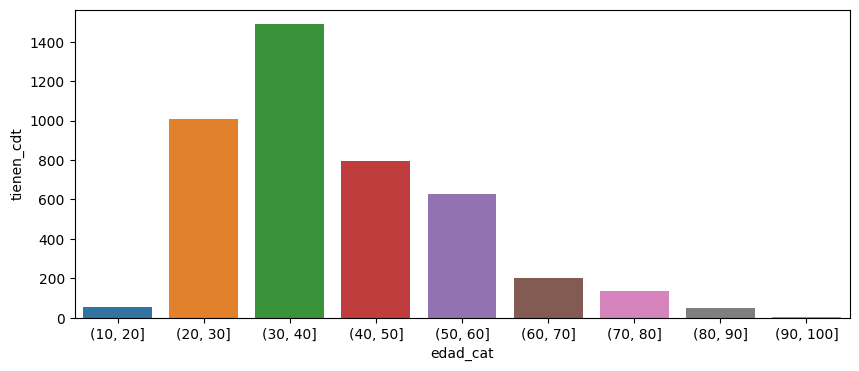

In [41]:
#edad (por rangos)
rangos = [10,20,30,40,50,60,70,80,90,100]
rangos_edad_df = train.copy()
rangos_edad_df['edad_cat'] = pd.cut(rangos_edad_df.age, bins=rangos) #Cut crea rangos

x = rangos_edad_df.groupby('edad_cat').agg(tienen_cdt=('target', 'sum')).reset_index()
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(data=x, x='edad_cat', y='tienen_cdt');

La gente que más pide CDTs son los clientes que tienen entre 30 a 40 años, seguido de los 20 a 30 y de los 40 a 50. Antes que eso posiblemente no hay tantos clientes por ser menores de edad, y después es probable que la propensión de la gente sea al gasto en vez de al ahorro

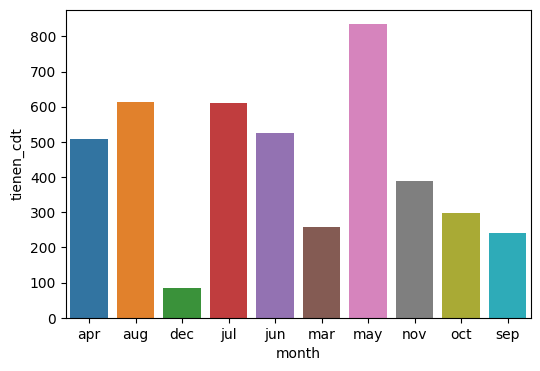

In [42]:
#month
cdt_month = train.groupby('month').agg(tienen_cdt=('target','sum')).reset_index()
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=cdt_month, x='month', y='tienen_cdt');

Hacen falta 2 meses, ambos pertenecientes al primer trimestre. Esa información podría ser muy importante de cara a datasets desconocidos que incluyan un año entero.

Se observa que se invierte menos en CDTs hacia finales de año.

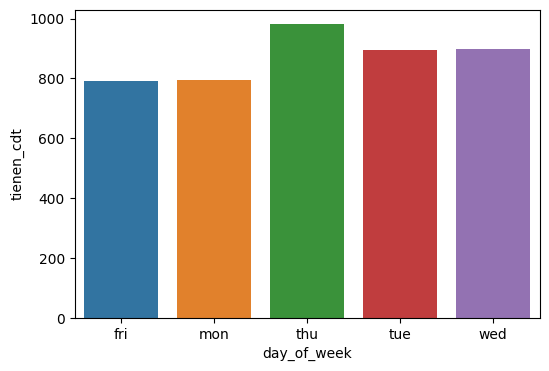

In [43]:
cdt_day = train.groupby('day_of_week').agg(tienen_cdt=('target','sum')).reset_index()
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=cdt_day, x='day_of_week', y='tienen_cdt');

Todas las categorías de esta variable tienen la misma cantidad, por lo que no es muy relevante.

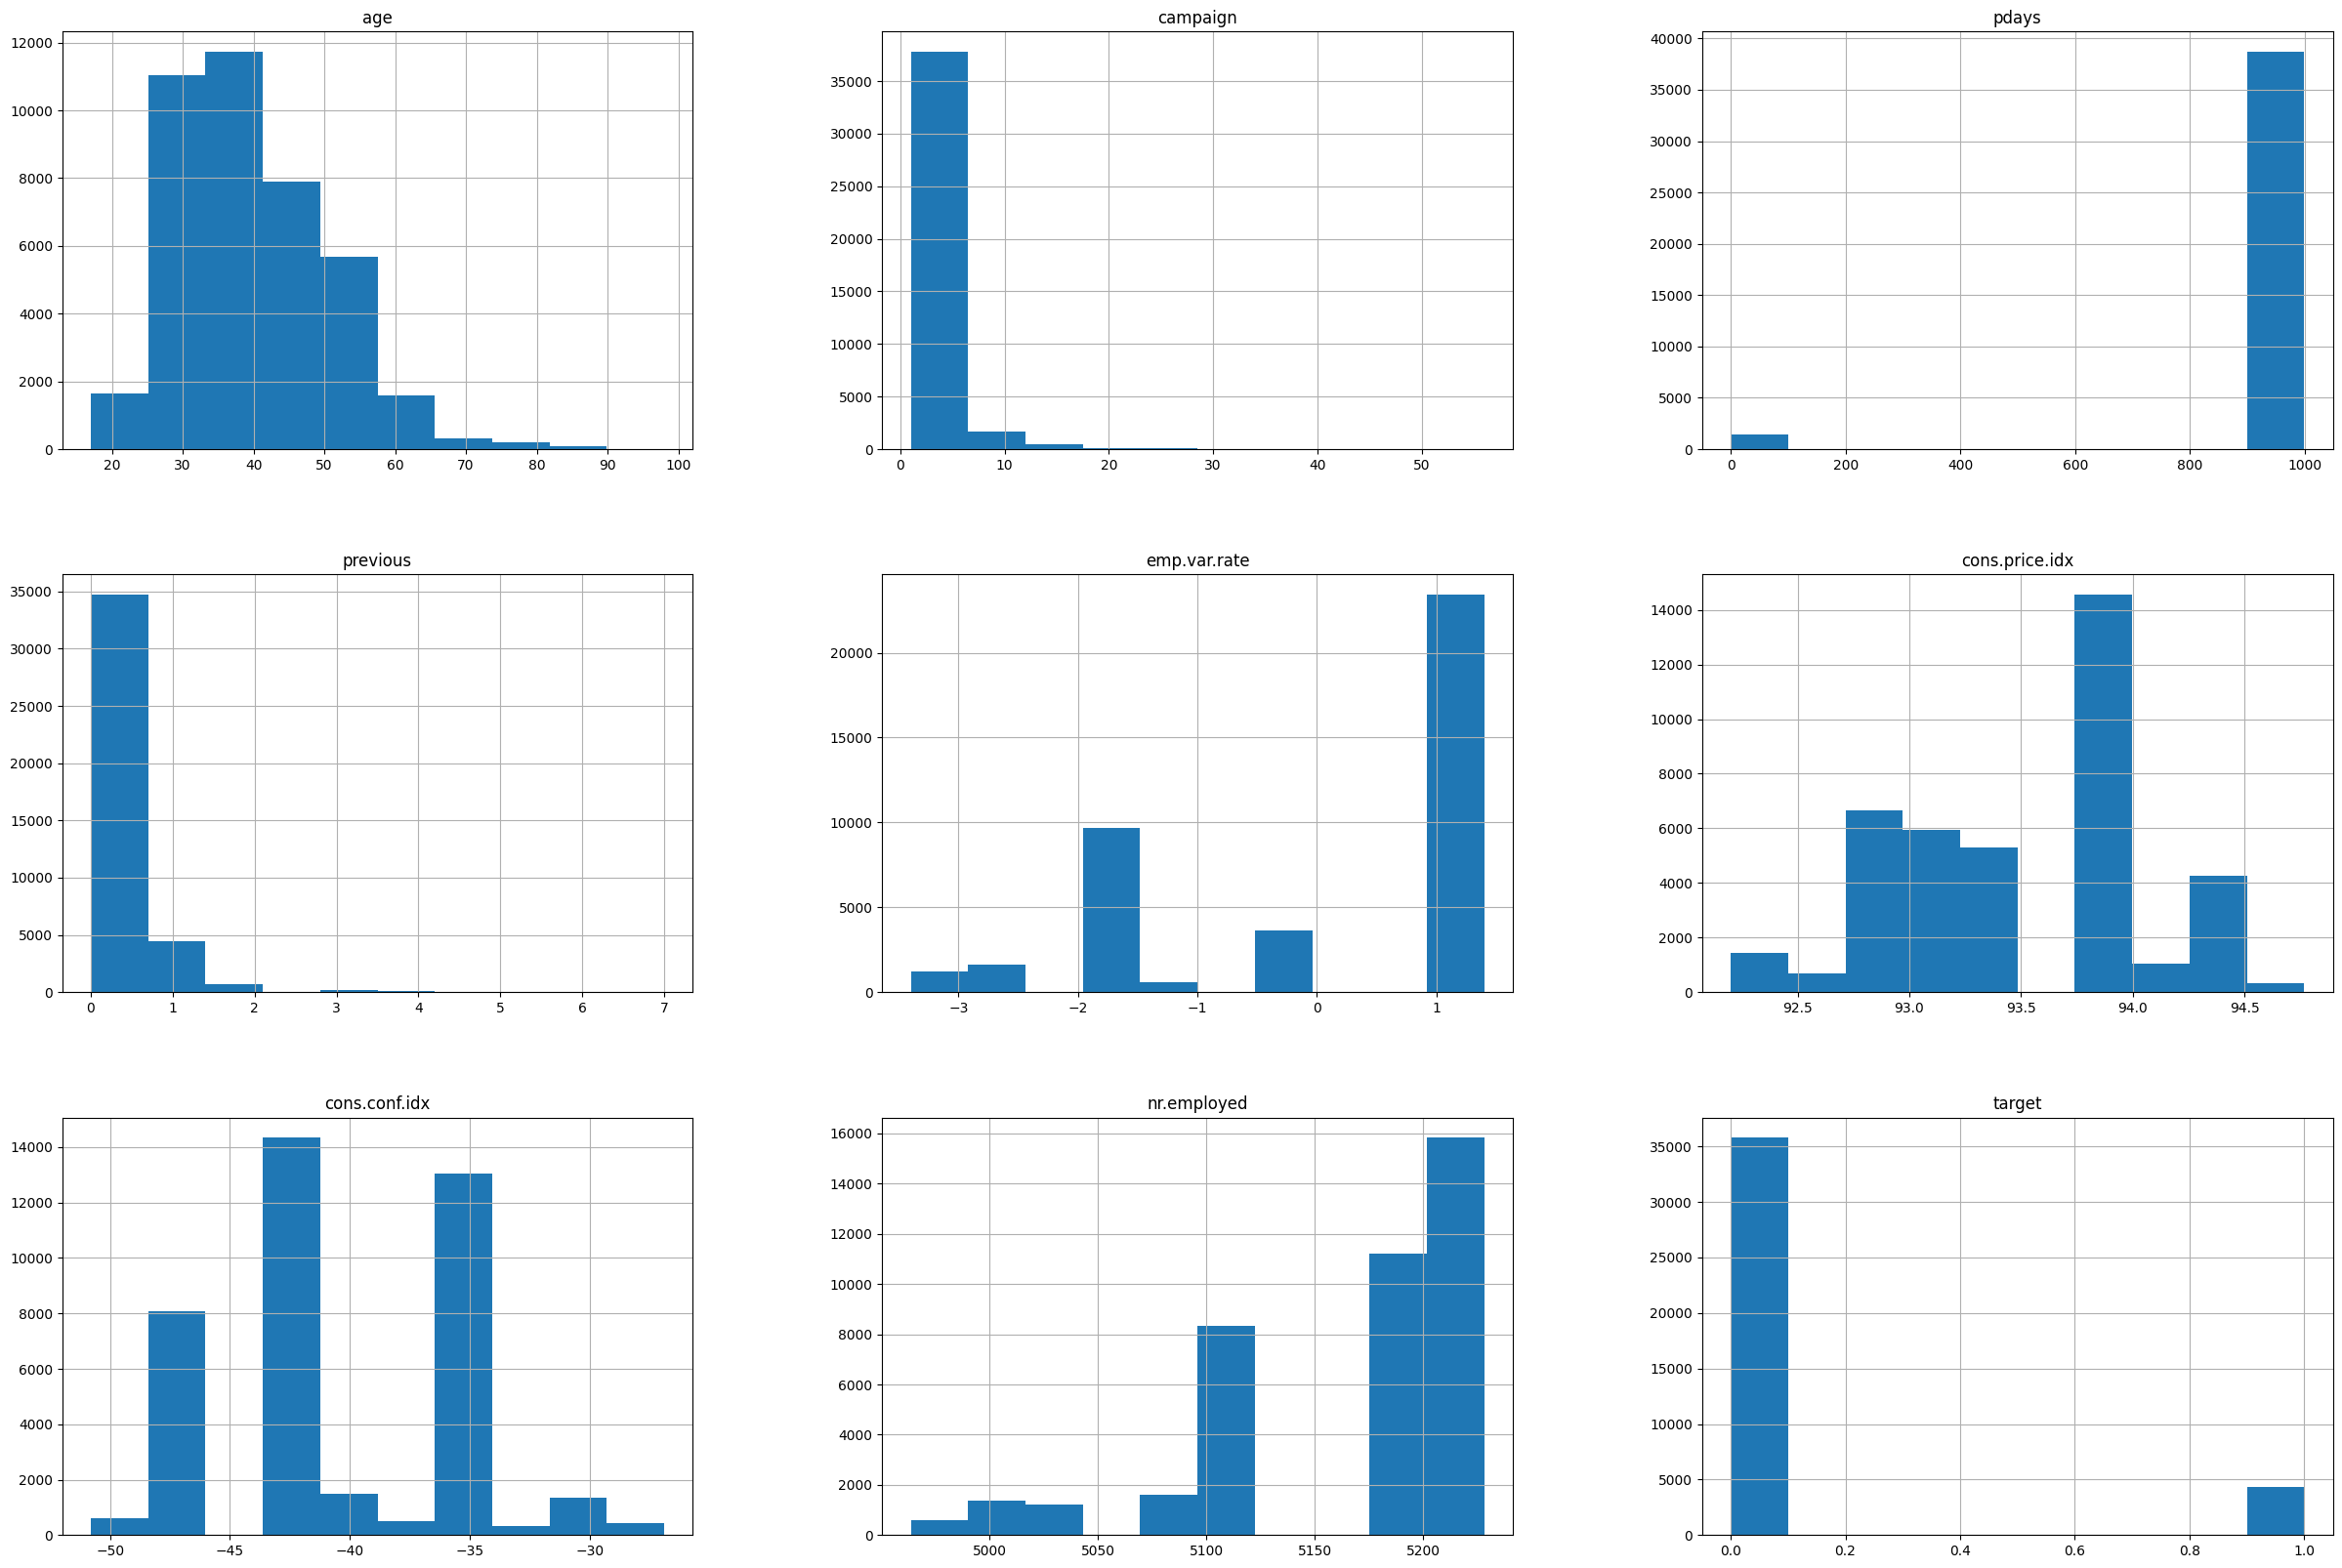

In [44]:
train.hist(figsize=(30,20));

Efectivamente, al ver la distribución de la variable objetivo, se observa que este se trata de un dataset desbalanceado

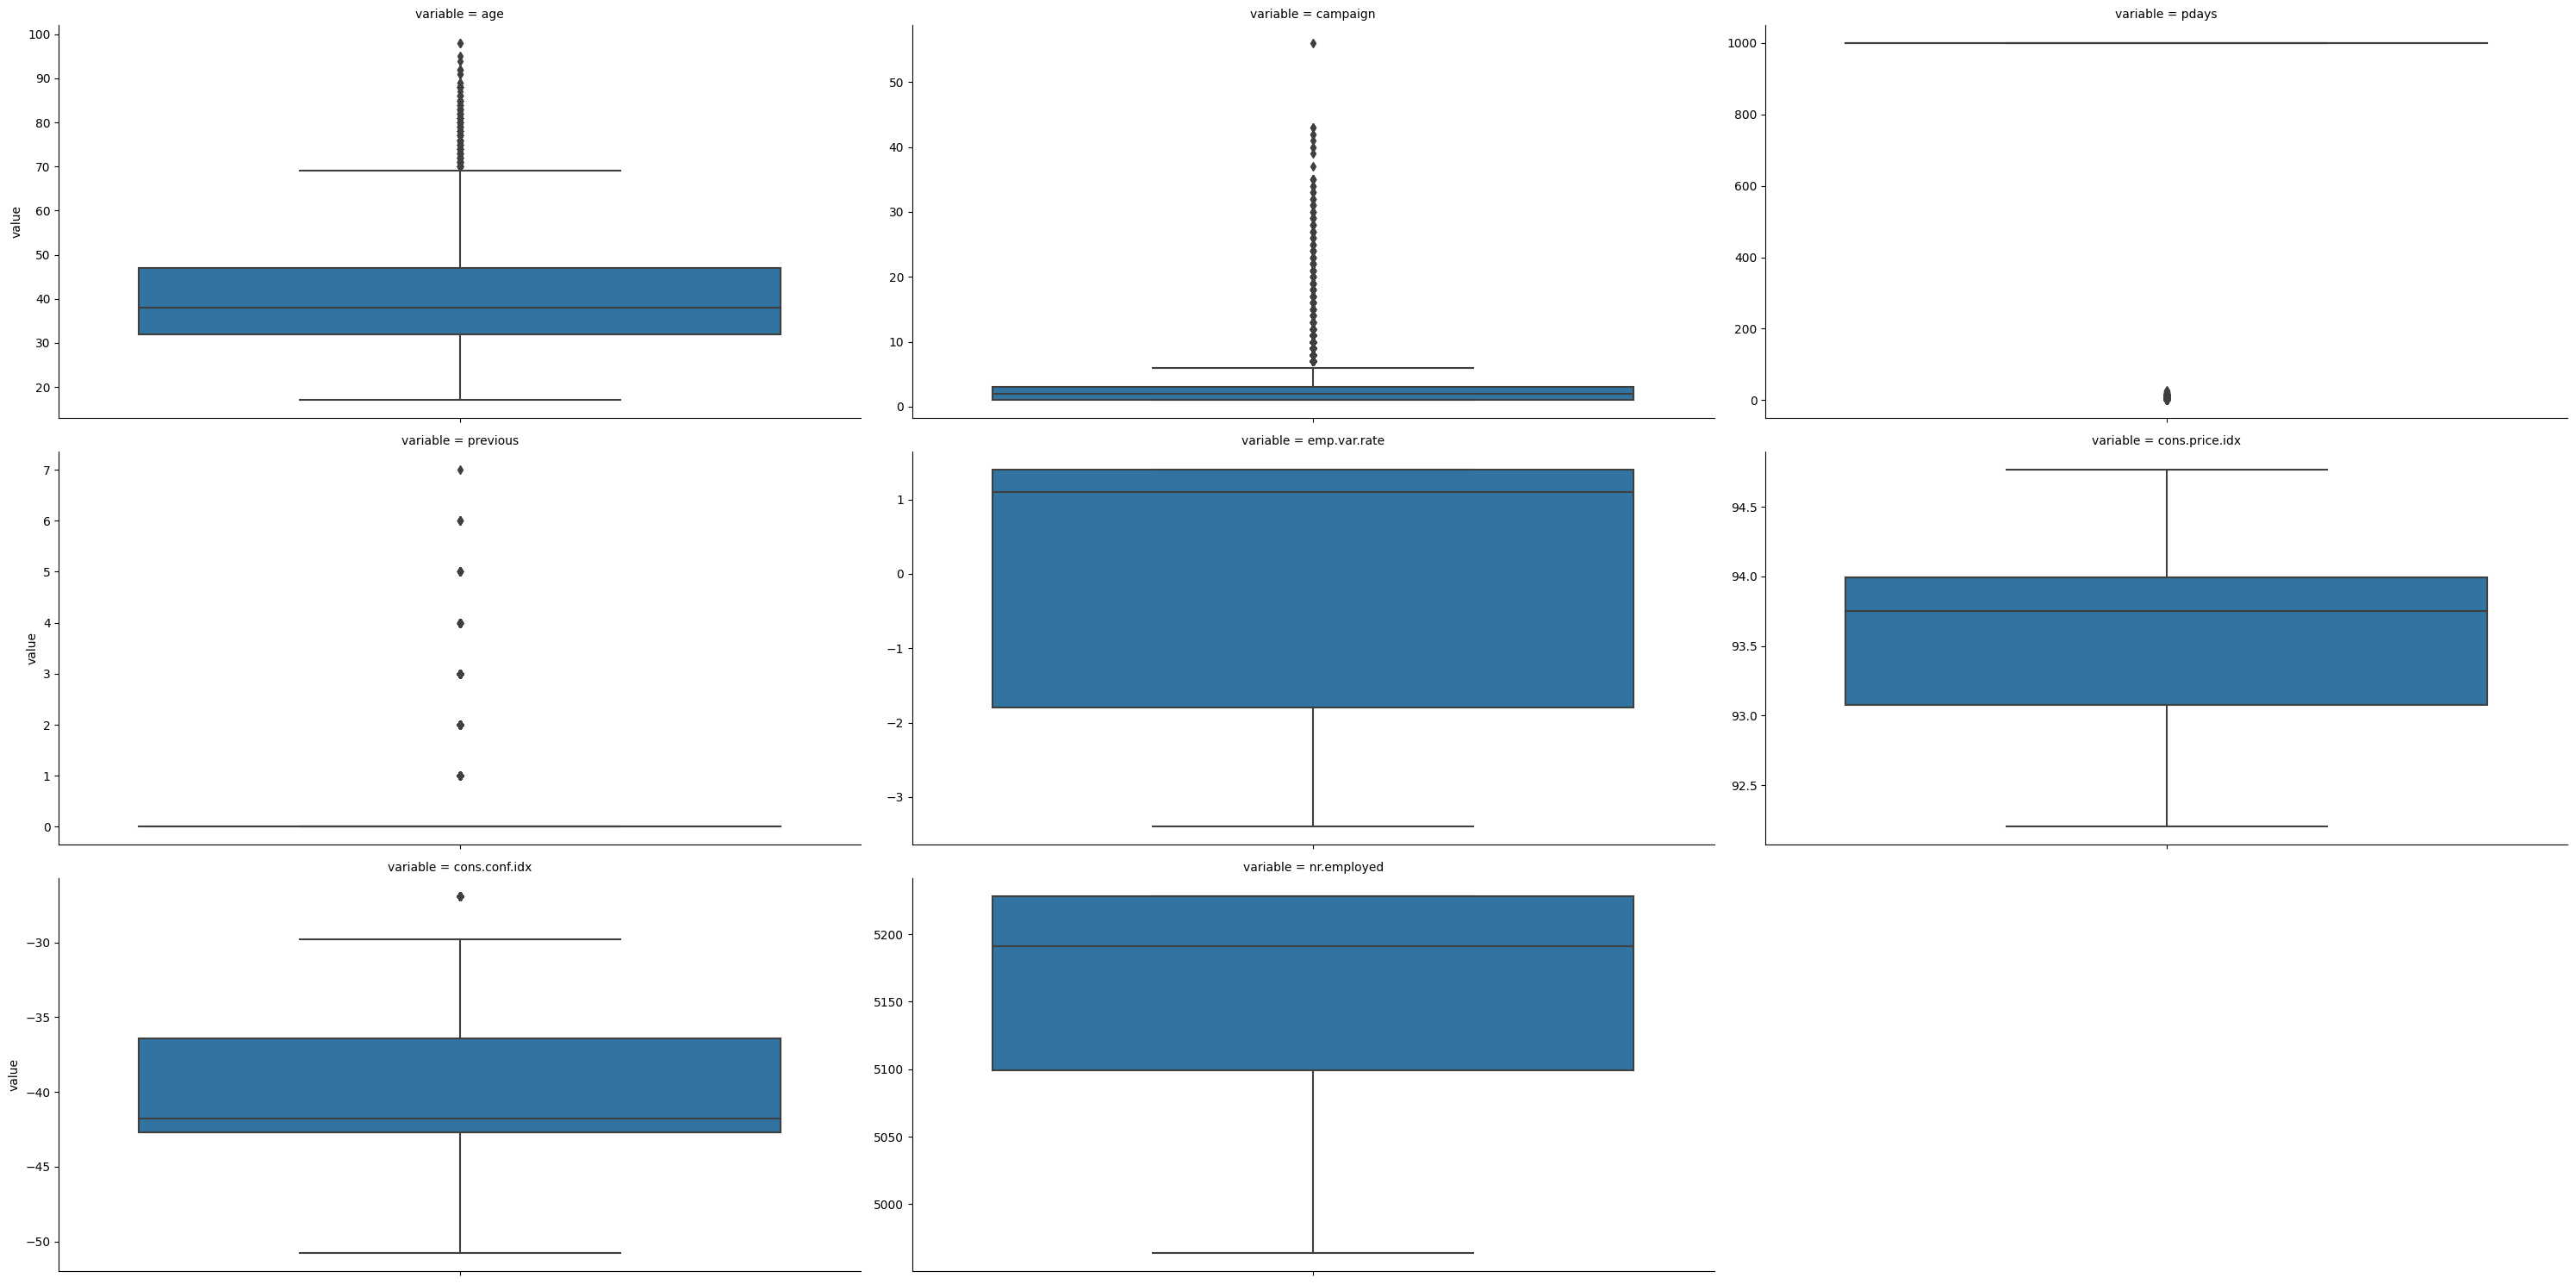

In [45]:
columnas_num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']
melt_num = pd.melt(train_pred.loc[:,train_pred.columns.isin(columnas_num)],value_vars=columnas_num)
sns.catplot(data=melt_num,y='value',col='variable',col_wrap=3,kind='box',sharey=False,aspect=2);

Por la información que se observa, las variables a las que se les tiene que ajustar los outliers son 'campaign' y 'cons_conf_idx'. Por otro lado, para la variable 'age', vale la pena modificarla por grupos, representando el grupo de edad al que pertenecen los clientes. Por su parte, 'pdays' también puede ser modificada, en este caso se cambiarán todos los valores iguales a 999 por 0, y todos los demás por 1, y así tener una variable binomial que de cuenta de si un cliente fue previamente llamado o no.

# 2) Limpieza de datos

In [46]:
#primero creamos una variables antes de tratar outliers
#Grupo de edad. Clasificado en 7 grupos diferentes
def age_group(age):
  edad = age
  if edad < 20: return 1
  elif edad < 30: return 2
  elif edad < 40: return 3
  elif edad < 50: return 4
  elif edad < 60: return 5
  elif edad < 75: return 6
  elif edad < 101: return 7
  else: return 0

train_pred['grupo_edad'] = train_pred.age.apply(lambda x: age_group(x))

### 2.1 Tratamiento de outliers

Es una de las partes más importantes, ya que nos permite evitar el sobreajuste

In [47]:
columnas_num = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed'] #nueva lista, esta vez sin pdays
for columna in columnas_num:
    q1 = train_pred[columna].quantile(0.25)
    q3 = train_pred[columna].quantile(0.75)
    iqr = q3-q1 
    limite_arriba = q3 + 1.5*iqr
    limite_abajo = q1 - 1.5*iqr
    mediana = train_pred.loc[train_pred[columna]<q3 + 1.5*iqr, columna].median()
    media = train_pred[columna].mean()
    train_pred.loc[train_pred[columna] > limite_arriba,columna] = np.nan
    train_pred[columna].fillna(limite_arriba, inplace=True)
    train_pred.loc[train_pred[columna] < limite_abajo,columna] = np.nan
    train_pred[columna].fillna(limite_abajo, inplace=True) 

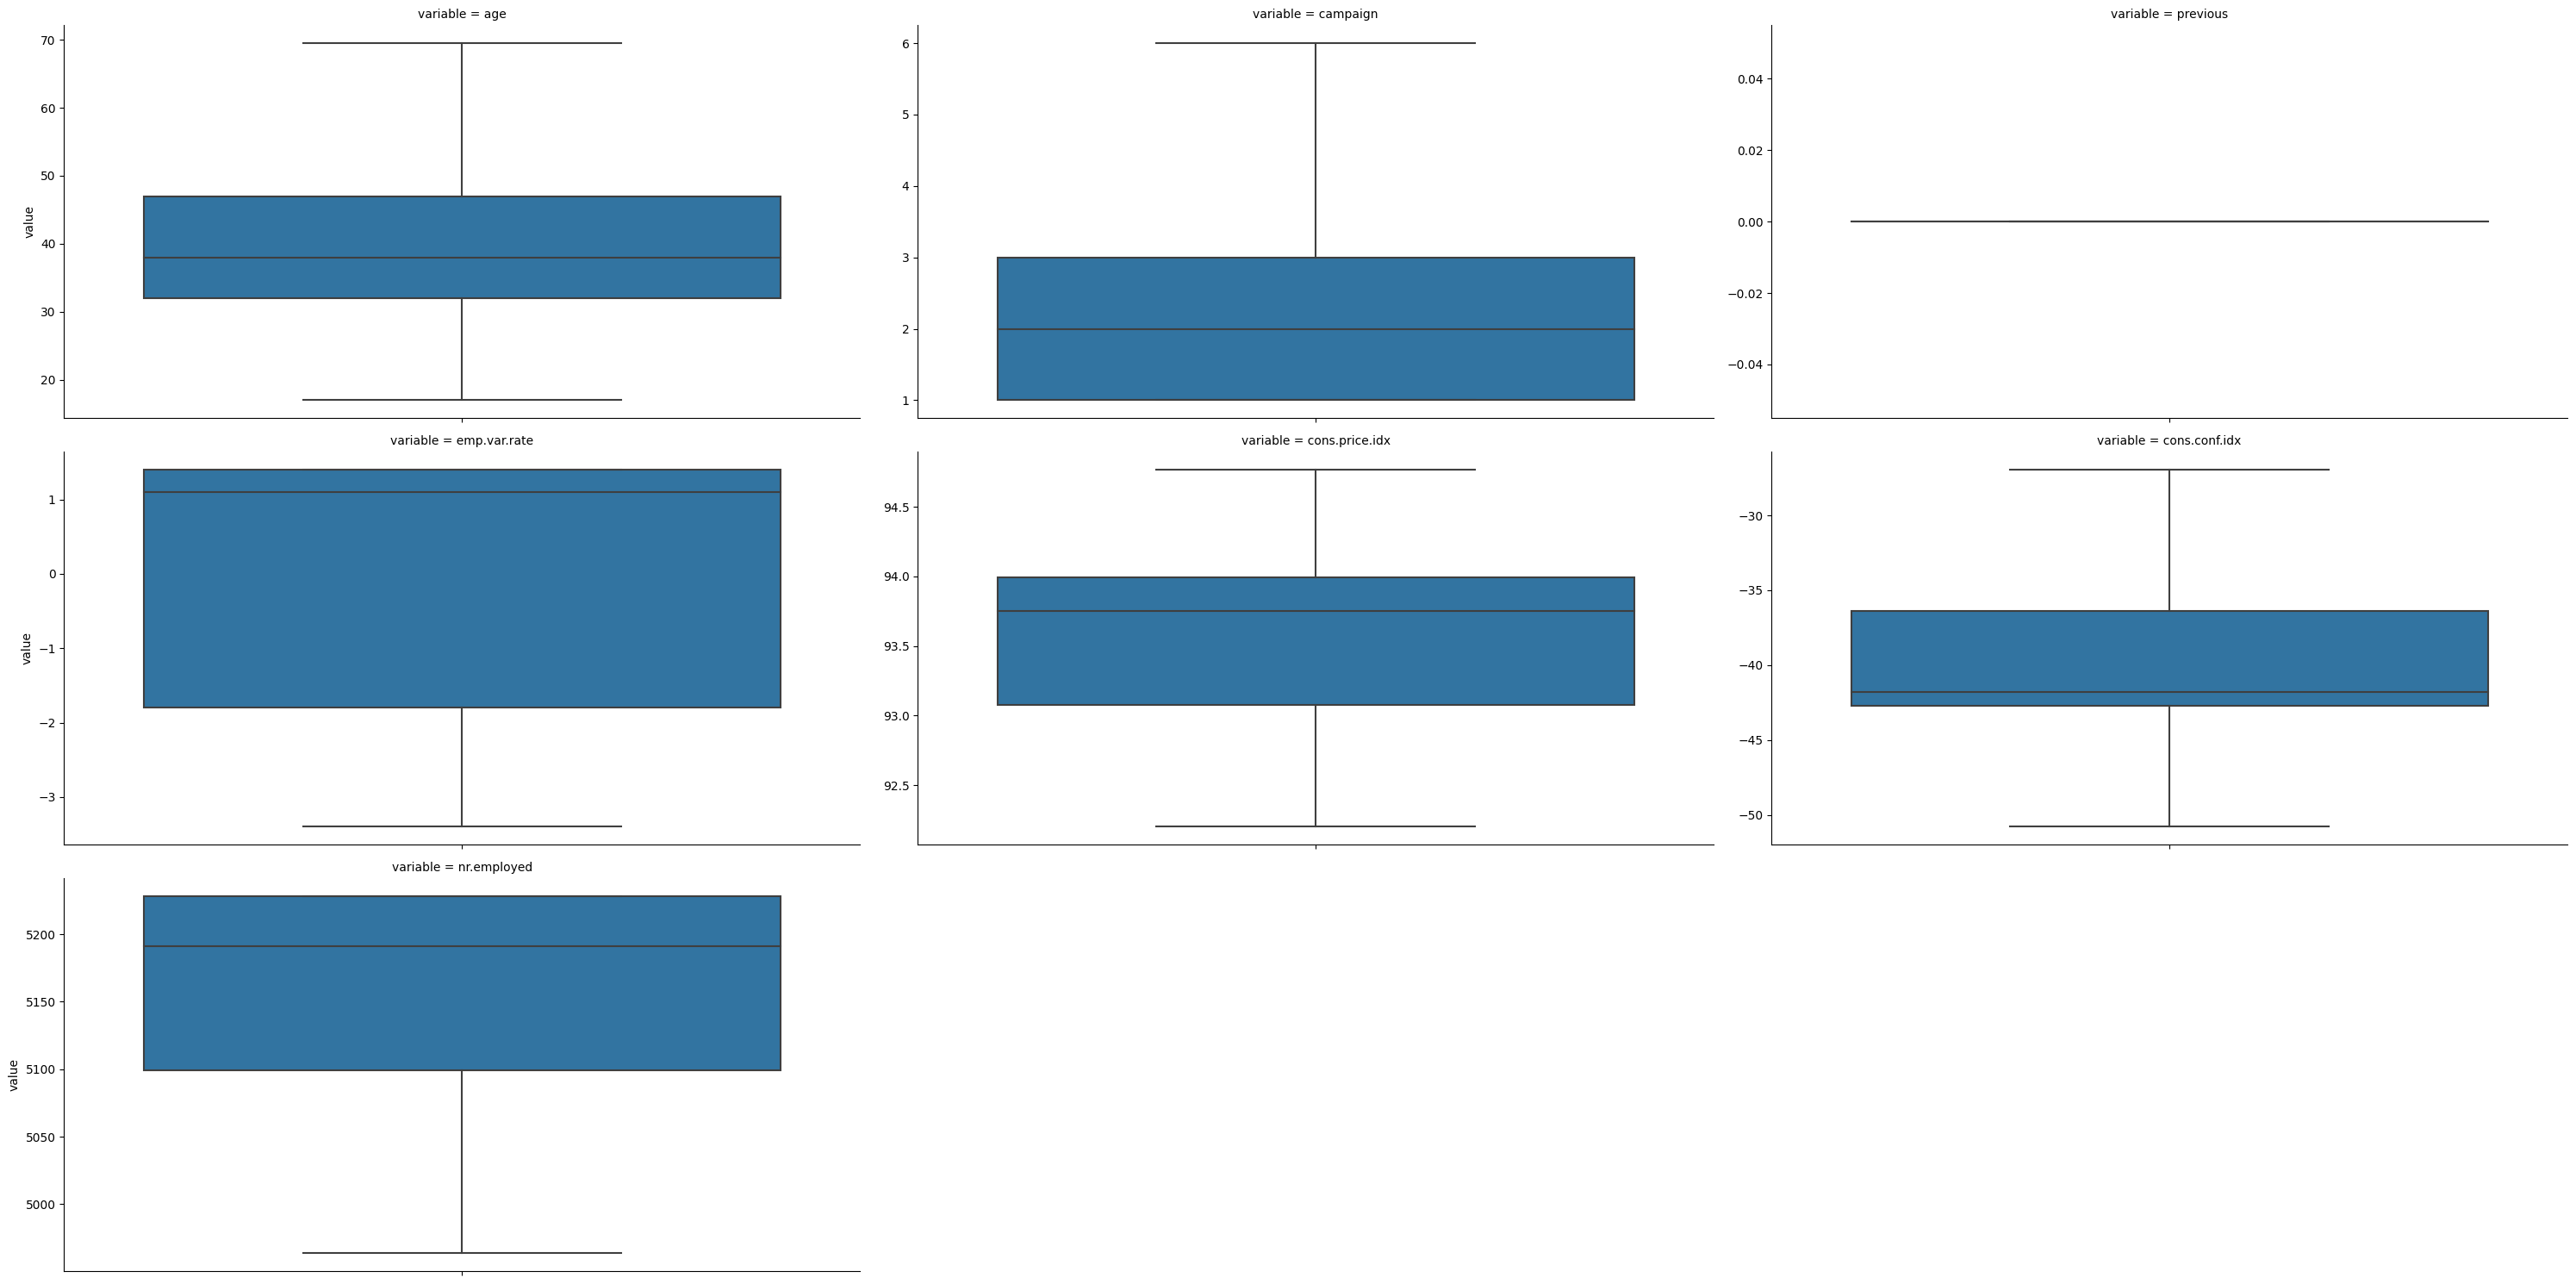

In [48]:
melt_num = pd.melt(train_pred.loc[:,train_pred.columns.isin(columnas_num)],value_vars=columnas_num)
sns.catplot(data=melt_num,y='value',col='variable',col_wrap=3,kind='box',sharey=False,aspect=2);

### 2.2 imputación de valores en variables categóricas

In [51]:
#Sustituir todos los valores 'unknown' de las variables categóricas por nan
for columna in train_pred.columns: 
  train_pred.loc[train_pred[columna]=="unknown", columna]=np.nan

train_pred.isna().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
nr.employed          0
target            1009
dataset              0
grupo_edad           0
dtype: int64

In [52]:
moda_job = train_pred.job.mode()[0]
train_pred.loc[train_pred.job.isna(), 'job'] = moda_job

moda_marital = train_pred.marital.mode()[0]
train_pred.loc[train_pred.job.isna(), 'marital'] = moda_marital

moda_education = train_pred.education.mode()[0]
train_pred.loc[train_pred.education.isna(), 'education'] = moda_education

moda_housing = train_pred.housing.mode()[0]
train_pred.loc[train_pred.housing.isna(), 'housing'] = moda_housing

moda_loan = train_pred.loan.mode()[0]
train_pred.loc[train_pred.loan.isna(), 'loan'] = moda_loan

### 2.3 Transformación variables

In [53]:
# Categóricas
## Education. Disminuir categorías para solo tener 3
train_pred['education'] = train_pred['education'].replace(['basic.4y', 'basic.6y','basic.9y'], 'basico')
train_pred['education'] = train_pred['education'].replace(['high.school', 'illiterate'], 'bachiller')
train_pred['education'] = train_pred['education'].replace(['university.degree', 'professional.course'], 'formal')

## Months. Disminur categorías, trimestral en vez de mensual
train_pred['month'] = train_pred['month'].replace('mar', 'trimestre_1')
train_pred['month'] = train_pred['month'].replace(['apr', 'may', 'jun'], 'trimestre_2')
train_pred['month'] = train_pred['month'].replace(['jul', 'aug', 'sep'], 'trimestre_3')
train_pred['month'] = train_pred['month'].replace(['oct', 'nov', 'dec'], 'trimestre_4')

# Numéricas. 0=cliente no fue contactado, 1=cliente fue contactado
def p_days(days):
  dias = days
  if dias > 998: return 0
  else: return 1

train_pred['p_days'] = train_pred.pdays.apply(lambda x: p_days(x))

In [54]:
train_pred.groupby('p_days').agg(dias=('p_days','count')).sort_values('dias',ascending=False)

,dias
p_days,
0,39673
1,1515


### 2.4 eliminación de variables

Las variables a eliminar se se hacen por las siguientes razones:
- default: Todos los datos dicen lo mismo, salvo por tres 'yes', por lo que no es una variable relevante.
- pdays: ya se creo otra variable con esta información, que seguramente resulta más útil
- day_of_week: Viendo la gráfica, no hay un día de la semana determinante en la obtención de CDT, por lo que no es una variable con gran relevancia
- previous: tras la eliminación de outliers, todos sus valores son 0, por lo que se entiende que casi toda la información que tenía esta variable era la misma
-age: Ya se creo otra variable (grupo_edad) que contiene la misma información

In [55]:
# eliminar variables no relevantes
col_eliminar = ['default','pdays','day_of_week','previous','age']
train_pred = train_pred.loc[:,~train_pred.columns.isin(col_eliminar)]
train_pred.head(3)

,job,marital,education,housing,loan,contact,month,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset,grupo_edad,p_days
id,,,,,,,,,,,,,,,,,
0,housemaid,married,basico,no,no,telephone,trimestre_2,1.0,nonexistent,1.1,93.994,-36.4,5191.0,0.0,train,5.0,0
1,services,married,bachiller,no,no,telephone,trimestre_2,1.0,nonexistent,1.1,93.994,-36.4,5191.0,0.0,train,5.0,0
2,services,married,bachiller,yes,no,telephone,trimestre_2,1.0,nonexistent,1.1,93.994,-36.4,5191.0,0.0,train,3.0,0


### 2.5 One hot encoding

In [56]:
# Variables categóricas sin jerarquía
le = LabelEncoder()

train_pred['job'] = le.fit_transform(train_pred.job)
train_pred['marital'] = le.fit_transform(train_pred.marital)
train_pred['month'] = le.fit_transform(train_pred.month)


# Variables categóricas con jerarquía o binomiales

train_pred['housing'] = pd.get_dummies(train_pred.housing, drop_first=True)
train_pred['loan'] = pd.get_dummies(train_pred.loan, drop_first=True)
train_pred['contact'] = pd.get_dummies(train_pred.contact, drop_first=True)

columnas_encodear = ['education','poutcome']
train_pred_ohe = pd.get_dummies(train_pred, columns=columnas_encodear, prefix='OHE')
train_pred_ohe.head(1)

,job,marital,housing,loan,contact,month,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,dataset,grupo_edad,p_days,OHE_bachiller,OHE_basico,OHE_formal,OHE_failure,OHE_nonexistent,OHE_success
id,,,,,,,,,,,,,,,,,,,,,
0,3,1,0,0,1,1,1.0,1.1,93.994,-36.4,5191.0,0.0,train,5.0,0,0,1,0,0,1,0


### 2.6 separación de datasets train y pred

In [57]:
train_df = train_pred_ohe.loc[train_pred_ohe.dataset=='train',train_pred_ohe.columns!='dataset']
pred_df = train_pred_ohe.loc[train_pred_ohe.dataset=='pred',train_pred_ohe.columns!='dataset']
train_df.head(1)

,job,marital,housing,loan,contact,month,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,target,grupo_edad,p_days,OHE_bachiller,OHE_basico,OHE_formal,OHE_failure,OHE_nonexistent,OHE_success
id,,,,,,,,,,,,,,,,,,,,
0,3,1,0,0,1,1,1.0,1.1,93.994,-36.4,5191.0,0.0,5.0,0,0,1,0,0,1,0


# 3) Clasificadores

In [58]:
X_train = train_df.loc[:,train_df.columns!='target']
y_train = train_df.target

In [59]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

#Se usa este código para balancear las clases, porque el datset está desbalanceado, lo que hace es un oversample
oversample = RandomOverSampler(sampling_strategy='minority', random_state=0)
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

### 3.1 arbol de decisión

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [61]:
X_test = pred_df.loc[:,pred_df.columns!='target']
X_test.isna().sum()

job                0
marital            0
housing            0
loan               0
contact            0
month              0
campaign           0
emp.var.rate       0
cons.price.idx     0
cons.conf.idx      0
nr.employed        0
grupo_edad         0
p_days             0
OHE_bachiller      0
OHE_basico         0
OHE_formal         0
OHE_failure        0
OHE_nonexistent    0
OHE_success        0
dtype: int64

In [62]:
modelo_arbol_podado = DecisionTreeClassifier(max_depth = 10, min_samples_split=70, min_samples_leaf=90)
modelo_arbol_podado.fit(X_resampled,y_resampled)

scores = cross_val_score(modelo_arbol_podado, X_resampled, y_resampled, cv = 10, scoring='accuracy')
print(scores.mean())

pred_arbol_pod = pd.DataFrame(modelo_arbol_podado.predict(X_test),columns=['target'],index=pred_df.index).reset_index()
pred_arbol_pod.target = pred_arbol_pod.target.astype(int)

0.5570195490926642


In [63]:
from google.colab import files

pred_arbol_pod.to_csv('prediccion12.csv',index=False)
files.download('prediccion12.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3.2 Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=44, min_samples_leaf=70, min_samples_split=100, max_depth=7)
modelo_rf.fit(X_resampled, y_resampled)

scores = cross_val_score(modelo_rf, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(scores.mean())

pred_random_forest = pd.DataFrame(modelo_rf.predict(X_test), columns=['target'], index=pred_df.index).reset_index()
pred_random_forest.target = pred_random_forest.target.astype(int)

0.4385057580075503


In [ ]:
from google.colab import files

pred_random_forest.to_csv('prediccion10_rf.csv',index=False)
files.download('prediccion10_rf.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3.3 Regresión logística

In [ ]:
scaler = MinMaxScaler()
train_norm = train_pred_ohe.loc[train_pred_ohe.dataset=='train',~train_pred_ohe.columns.isin(['dataset','target'])]
train_norm = pd.DataFrame(scaler.fit_transform(train_norm),index=train_norm.index,
                      columns=train_norm.columns)

test_norm = train_pred_ohe.loc[train_pred_ohe.dataset=='pred',~train_pred_ohe.columns.isin(['dataset','target'])]
test_norm = pd.DataFrame(scaler.fit_transform(test_norm),index=test_norm.index,
                      columns=test_norm.columns)

In [ ]:
reg_log = linear_model.LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced')
reg_log.fit(train_norm, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', penalty=None)

In [ ]:
puntaje2=cross_val_score(reg_log,train_norm,y_train,cv=10,scoring='accuracy')
puntaje2.mean()

0.6504770479568355

In [ ]:
pred_rl = pd.DataFrame(reg_log.predict(test_norm),columns=['target'],index=pred_df.index).reset_index()
pred_rl.target = pred_rl.target.astype(int)

In [ ]:
from google.colab import files

pred_rl.to_csv('prediccion8_rl.csv',index=False)
files.download('prediccion8_rl.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>